In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import time
from sklearn.feature_selection import RFECV

### Preparing dataset

In [2]:
df = pd.read_parquet("../data/final_merged_dataset.parquet")

In [3]:
df

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,source_AMBCrypto,source_BeInCrypto,source_Benzinga,...,lower_band_10,upper_band_20,middle_band_20,lower_band_20,10_band_width,pct_b_10,20_band_width,pct_b_20,reddit_total_sentiment,reddit_average_sentiment
2021-01-01 06:00:00,2.0,0.850000,0.000,0.00,0.0,0.150,0.0,0.0,0.0,0.0,...,28401.688294,29450.949582,28913.7180,28376.486418,0.039453,0.942558,0.037161,1.026218,-0.891,-0.111375
2021-01-01 07:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,28615.454707,29488.063359,28931.4545,28374.845641,0.030480,0.715670,0.038478,0.785547,0.000,0.000000
2021-01-01 08:00:00,2.0,0.400000,0.000,0.00,0.0,0.500,0.0,0.0,1.0,0.0,...,28782.451560,29515.716093,28939.8210,28363.925907,0.024058,0.803534,0.039799,0.852329,0.000,0.000000
2021-01-01 09:00:00,2.0,-0.050000,0.000,0.00,0.0,0.400,0.0,0.0,0.0,0.0,...,28839.212780,29553.465096,28957.6910,28361.916904,0.022668,0.682311,0.041148,0.779207,0.000,0.000000
2021-01-01 10:00:00,3.0,0.766667,0.000,0.00,0.0,0.300,0.0,1.0,0.0,0.0,...,28901.714287,29578.630359,28970.1450,28361.659641,0.020372,0.572225,0.042008,0.723469,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 00:00:00,4.0,0.025000,0.175,0.30,0.0,0.325,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:00:00,1.0,0.800000,0.000,0.00,0.0,0.000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 02:00:00,2.0,0.050000,0.000,0.00,0.0,0.250,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 03:00:00,2.0,0.500000,-0.100,0.00,0.0,0.000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Create 3-class target:
df['target'] = np.where(df['return_forward'] > 0.001, 2,
                        np.where(df['return_forward'] < -0.001, 0, 1))

print("Target class distribution:")
print(df['target'].value_counts())

Target class distribution:
target
2    13105
0    12641
1     9317
Name: count, dtype: int64


In [5]:
# list of features column names
all_features = df.columns.drop(['target', 'return_forward', 'year'])

KeyError: "['year'] not found in axis"

### Logistic Regression Model Implementation

We'll implement a logistic regression model with feature selection using RFE and hyperparameter tuning using GridSearchCV.

In [ ]:
# 1. Prepare the datasets
print("\n1. Preparing datasets...")

df['year'] = df.index.year
train_data_2021_2022 = df[df['year'].isin([2021, 2022])]
validation_data_2023 = df[df['year'] == 2023]
test_data_2024 = df[df['year'] == 2024]

X_train = train_data_2021_2022[all_features]
y_train = train_data_2021_2022['target']
X_val = validation_data_2023[all_features]
y_val = validation_data_2023['target']
X_test = test_data_2024[all_features]
y_test = test_data_2024['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Validation set class distribution: {np.bincount(y_val)}")
print(f"Test set class distribution: {np.bincount(y_test)}")


1. Preparing datasets...
Training set class distribution: [7186 3071 7257]
Validation set class distribution: [2807 2967 2986]
Test set class distribution: [2648 3274 2862]


In [ ]:
# 2. Feature scaling
print("\n2. Scaling features...")

# Clean data by replacing infinite values with NaN and filling them with 0
def clean_data(X):
	return X.replace([np.inf, -np.inf], np.nan).fillna(0)

X_train_clean = clean_data(X_train)
X_val_clean = clean_data(X_val)
X_test_clean = clean_data(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_val_scaled = scaler.transform(X_val_clean)
X_test_scaled = scaler.transform(X_test_clean)


2. Scaling features...


In [ ]:
# 3. Feature selection using RFE
print("\n3. Performing feature selection...")
start_time = time.time()

base_model = LogisticRegression(
    multi_class='multinomial',  # Explicitly handle multiclass
    solver='lbfgs',            # Supports multinomial loss + faster convergence
    class_weight='balanced',   # Address class imbalance
    max_iter=5000,             # Ensure convergence
    random_state=42,           # Reproducibility
    C=0.1                      # Start with stronger regularization
)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Test regularization strengths
    'solver': ['lbfgs', 'sag', 'saga']     # Solvers supporting multinomial
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=5000,
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,                  # 3-fold cross-validation
    scoring='accuracy',    # Metric to optimize
    n_jobs=-1              # Parallelize computation
)

rfecv = RFECV(
    estimator=best_logreg,
    step=1,
    cv=3,                  # 3-fold time-series CV
    scoring='accuracy',
    min_features_to_select=20  # Lower bound for features
)

# Fit RFECV
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal features: {rfecv.n_features_}")


3. Performing feature selection...
Selected 50 features out of 118
Top 10 selected features:
  1. open
  2. high
  3. low
  4. close
  5. sma_5
  6. sma_20
  7. sma_50
  8. sma_200
  9. ema_5
  10. ema_20
Feature selection completed in 1.66 minutes


In [ ]:
# 4. Grid Search on the reduced feature set
print("\n4. Performing grid search for hyperparameter tuning...")
start_time = time.time()
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],  # l2 penalty works with all solvers
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'multi_class': ['ovr', 'multinomial']  # One-vs-rest or multinomial
}

# Run grid search
lr_model = LogisticRegression(max_iter=3000, class_weight='balanced')
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train_rfe, y_train)

# Display the best parameters
print(f"\nBest parameters found: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
print(f"Grid search completed in {(time.time() - start_time)/60:.2f} minutes")


4. Performing grid search for hyperparameter tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\phku0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Best parameters found: {'C': 10.0, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
Grid search completed in 1.56 minutes


In [ ]:
# 5. Evaluate on validation data
print("\n5. Evaluating on validation data (2023)...")
y_val_pred = best_model.predict(X_val_rfe)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='macro')

print(f"\nValidation Results (2023 data):")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(classification_report(y_val, y_val_pred))


5. Evaluating on validation data (2023)...

Validation Results (2023 data):
Accuracy: 0.3855
Precision: 0.4307
Recall: 0.3812
F1 Score: 0.3001
              precision    recall  f1-score   support

           0       0.40      0.11      0.18      2807
           1       0.37      0.91      0.53      2967
           2       0.52      0.12      0.20      2986

    accuracy                           0.39      8760
   macro avg       0.43      0.38      0.30      8760
weighted avg       0.43      0.39      0.30      8760



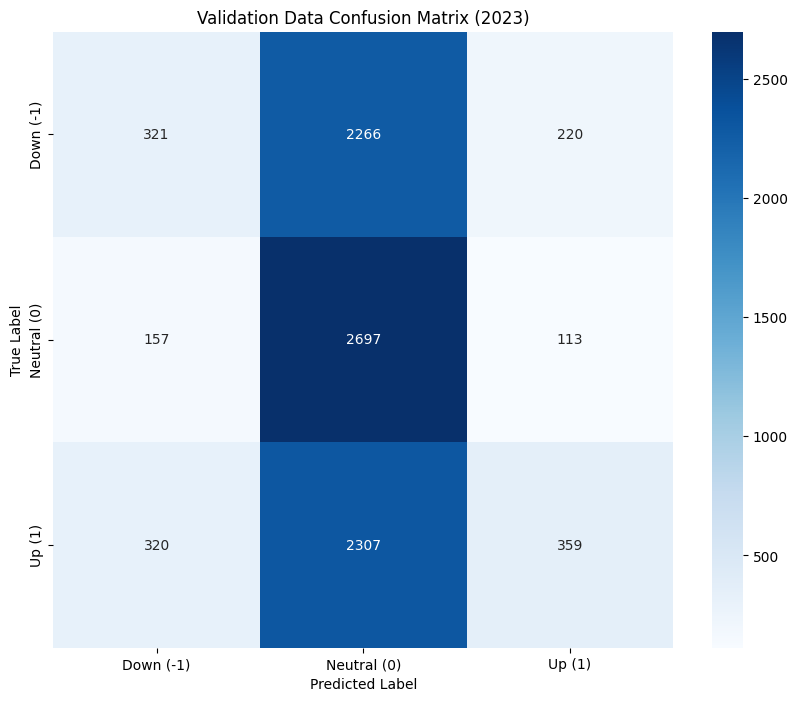

In [ ]:
# Visualize validation confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down (-1)', 'Neutral (0)', 'Up (1)'],
            yticklabels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
plt.title('Validation Data Confusion Matrix (2023)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# 6. Combine training and validation data and retrain
print("\n6. Retraining model on combined 2021-2023 data...")
X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.concatenate((y_train, y_val))

# Apply the same feature selection
X_combined_rfe = rfe.transform(X_combined)

# Train the final model with the best parameters
final_model = LogisticRegression(**grid_search.best_params_, max_iter=3000, class_weight='balanced')
final_model.fit(X_combined_rfe, y_combined)

print("Final model trained on combined data.")


6. Retraining model on combined 2021-2023 data...


c:\Users\phku0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Final model trained on combined data.


In [ ]:
# 7. Evaluate on test data
print("\n7. Evaluating final model on test data (2024)...")
y_test_pred = final_model.predict(X_test_rfe)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f"\nTest Results (2024 data):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(classification_report(y_test, y_test_pred))


7. Evaluating final model on test data (2024)...

Test Results (2024 data):
Accuracy: 0.4828
Precision: 0.4730
Recall: 0.4733
F1 Score: 0.4685
              precision    recall  f1-score   support

           0       0.39      0.43      0.41      2648
           1       0.57      0.65      0.61      3274
           2       0.46      0.34      0.39      2862

    accuracy                           0.48      8784
   macro avg       0.47      0.47      0.47      8784
weighted avg       0.48      0.48      0.48      8784



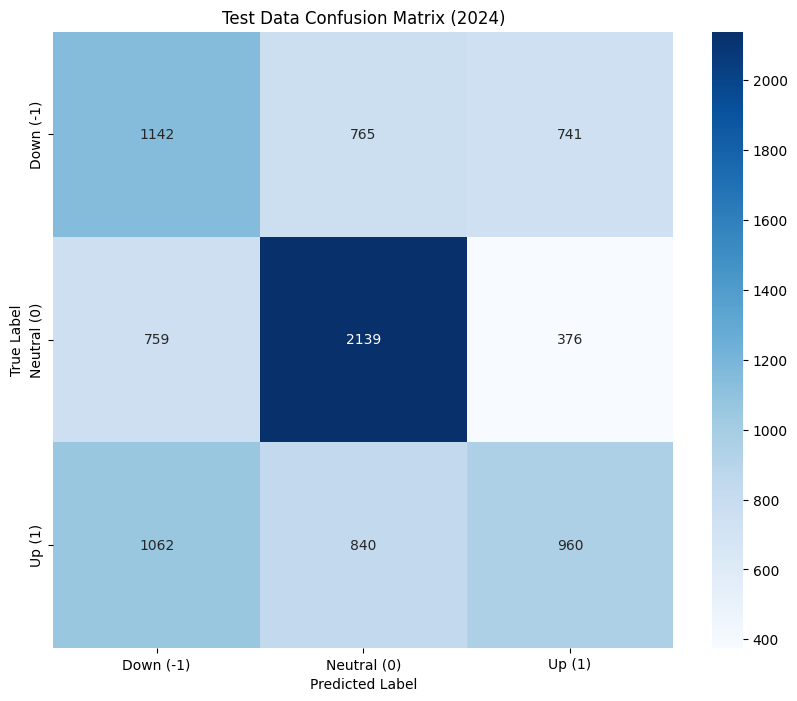

In [ ]:
# Visualize test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down (-1)', 'Neutral (0)', 'Up (1)'],
            yticklabels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
plt.title('Test Data Confusion Matrix (2024)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# 8. Feature importance analysis
print("\n8. Analyzing feature importance...")
# For multi-class models, average the absolute values across classes
if len(final_model.coef_) > 1:  # Multi-class case
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': np.mean(np.abs(final_model.coef_), axis=0)
    })
else:  # Binary class or OvR
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': np.abs(final_model.coef_[0])
    })

feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Print top important features
print("\nTop 10 most important features:")
for i, (feature, importance) in enumerate(zip(feature_importance['Feature'].head(10), 
                                             feature_importance['Importance'].head(10))):
    print(f"{i+1}. {feature}: {importance:.4f}")


8. Analyzing feature importance...

Top 10 most important features:
1. upper_band_20: 4.5257
2. lower_band_20: 4.1135
3. open: 2.2792
4. macd_histogram: 1.9513
5. ema_5_20_diff: 1.7120
6. trailing_stop_long_7: 1.6018
7. trailing_stop_long_14: 1.5823
8. high: 1.5614
9. macd_12_26: 1.3479
10. ema_20_50_diff_abs_chg: 1.2658


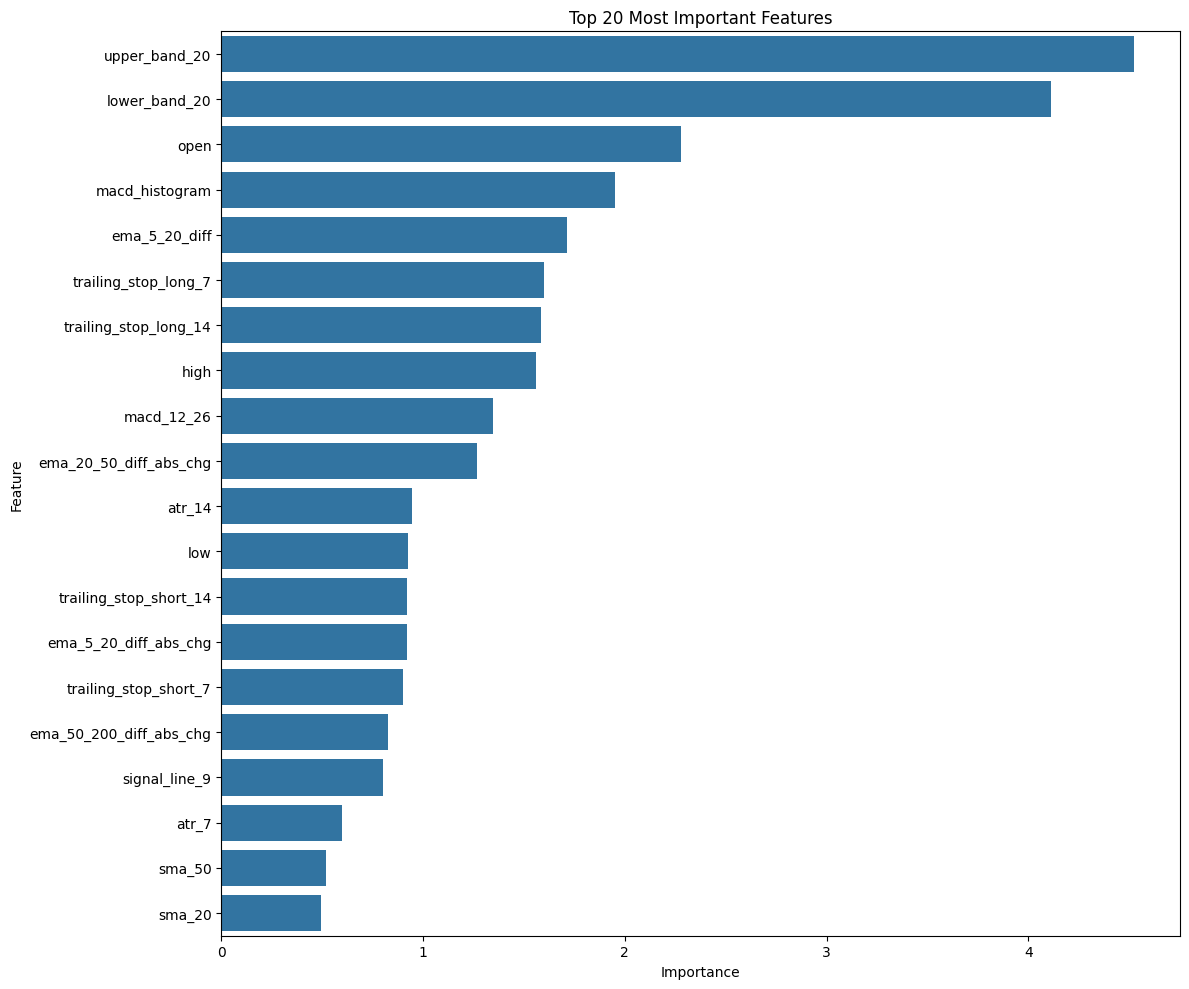

In [ ]:
# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
# 9. Summary of results
print("\n9. Summary of logistic regression analysis:")
print(f"- Number of features used: {len(selected_features)}")
print(f"- Best model parameters: {grid_search.best_params_}")
print(f"- Validation accuracy: {val_accuracy:.4f}")
print(f"- Final test accuracy: {test_accuracy:.4f}")
print("- Class-wise performance on test data:")
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred)
for i, label in enumerate(['Down (-1)', 'Neutral (0)', 'Up (1)']):
    print(f"  {label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")


9. Summary of logistic regression analysis:
- Number of features used: 50
- Best model parameters: {'C': 10.0, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
- Validation accuracy: 0.3855
- Final test accuracy: 0.4828
- Class-wise performance on test data:
  Down (-1): Precision=0.3854, Recall=0.4313, F1=0.4071
  Neutral (0): Precision=0.5713, Recall=0.6533, F1=0.6096
  Up (1): Precision=0.4622, Recall=0.3354, F1=0.3887


### Model Performance Analysis

Based on the results above, let's analyze what we've observed and extract insights from our logistic regression model:

1. **Feature Selection**: The RFE algorithm selected the most important features for prediction, which helps reduce dimensionality and possible overfitting.

2. **Model Parameters**: The grid search found the optimal parameters for our task, balancing model complexity and performance.

3. **Performance Metrics**: 
   - Validation accuracy gives us an estimate of how well our model performs on unseen data
   - Final test accuracy shows the true performance on 2024 data
   - Class-specific metrics (precision, recall, F1) indicate how well we're handling each movement direction

4. **Feature Importance**: The feature importance visualization reveals which indicators are most valuable for price movement prediction.

Next steps could include:
1. Trying different feature selection methods
2. Comparing with other classification algorithms
3. Implementing a trading strategy based on these predictions